# LINCS Publications & Citations Report

*Created by Brian M. Schilder, Moshe Silverstein, and Alexandra Keenan on 09/22/2018.*

In [2]:
%matplotlib inline

import sys
print (sys.version)
# token: 428145730f2d00b0596bd2521918df095fc272a23500acb4
import os
os.getcwd()
os.chdir('../LINCS-Publications-Report')

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary
- Plots:
	- Publications over time
	- Citations over time


- Repeat these plots for each of the following groupings:
	- Aggregated across internal LINCS centers

	- Divided amongst internal LINCS centers (label by center, not PI)
		1. Data Coordination and Integration Center (Mount Sinai, Avi Ma’ayan)
		2. Drug Toxicity Signature Generation Center (Mount Sinai, Ravi Iyengar)
		3. LINCS Proteomic Characterization Center for Signaling and Epigenetics (Broad Institute, Jacob Jaffe)
		4. Microenvironment Perturbagen (MEP) LINCS Center (Oregon Health & Science University, Joe Gray)
		5.	HMS LINCS Center (Peter Sorger)
		6.	LINCS Center for Transcriptomics (Broad Institute, Todd Golub)
		7.	NeuroLINCS Center  (UC-Irvine, Leslie Thompson)
	- Across all groups external to LINCS (E.g. papers that used L1000, Canvas Browser).; 

### Import Data

In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sn.set_style('whitegrid')
sn.set(font_scale=1.5) 
# Author info from LINCS database (collected 
authors = pd.read_table('authors.tsv')
authors.rename(columns={'id':'author_id'}, inplace=True)

authors_pubs = pd.read_table('authors_publications.tsv')
authorKey = authors.merge(authors_pubs, on='author_id')


# Publications (internal and external to the LINCS centers)
# Collected by Moshe Silverstein
## had to manually correct a couple errors in file
pubs = pd.read_table('publications.tsv') 
# Fill missing pub ids
maxID = int(max(pubs['id']))
fillerIDs = pd.Series(range(maxID, maxID+sum(pd.isnull(pubs['id'])) ))
pubs.fillna(fillerIDs, inplace=True)
# Rename cols
pubs.rename(columns={'id':'publication_id'}, inplace=True)  
# pubs['publication_id'] = pubs['publication_id'].astype(int)

# Get authors and concatenate
pubs_tmp = pubs.merge(authorKey, on='publication_id')
authorsConcat = pubs_tmp.groupby('publication_id')['name'].apply(lambda x: "%s" % ', '.join(x)).reset_index()
authorsConcat.rename(columns={'name':'authors'}, inplace=True) 
pubs = pubs.merge(authorsConcat, on='publication_id').drop_duplicates()  
pubs.columns
# Additional publications (internal and external to the LINCS centers)
#  collected by Alexandra Keenan
pubs2 = pd.read_csv('additional_pubs.csv')

def externalInternal(val):
    if val == 'outside':
        return 0
    else:
        return 1
pubs2['center_pub'] = pubs2['center'].apply(externalInternal)
pubs2 = pubs2.rename(columns={'PMID':'pm_id', 'year':'year_published', 'title':'article_name'})
pubs2['publication_id'] = max(pubs['publication_id'].astype(int)) 
pubs_extended = pd.concat([pubs, pubs2],axis=0,  ignore_index=True) 


## Get Citations from PubMed API
Documentation: 
- https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
- https://www.ncbi.nlm.nih.gov/books/NBK25497/

Note: To use the API you must first register your tool and email with NCBI by emailing eutilities@ncbi.nlm.nih.gov;

In [4]:
pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?'+\
             'dbfrom=pubmed&linkname=pmc_pmc_citedby&id='

tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu' 
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMClist = pubs_extended['pmc_id'].str.strip('PMC').str.strip(' ').astype(str)
PMClist = PMClist[PMClist!='nan']
urls = pubmed_url+PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey
url=urls[0]

import xmltodict, time
from requests import get
def getCitations(url): 
    PMC = url.split('&id=')[1].split("&tool")[0] 
    response = get(str(url))
    citDict = xmltodict.parse(response.content)
    try:
        citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
        allCitations = [x['Id'] for x in citationInfo ] 
        pmcList = list(set(allCitations)) # Get unique citations
        status = str(len(pmcList))+' citations found'
        # Can only submit up to 10 requests/second
        time.sleep(.11)
    except:
        pmcList = [] 
        status = 'None found'
    print("Extracting Citations for PMC : "+PMC+"........ "+status)
    return pmcList


res = list(map(getCitations, urls))
results = dict(zip(PMClist, res))





# Get the year each paper cited the LINCS paper
## Documentation: https://www.ncbi.nlm.nih.gov/pmc/tools/get-metadata/
pubmed_url2 =  'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?'+\
               'db=pmc&retmode=json&id='
import urllib.request, json, time 
def getYearPublished(url):
    PMC = url.split('&id=')[1].split("&tool")[0] 
    try:
        with urllib.request.urlopen(url) as URL:
            citDict = json.loads(URL.read().decode()) 
        
            pubDate = citDict['result'][PMC]['epubdate']
            year = int(pubDate.split(" ")[0])
            status = str('Citation created : '+str(year)) 
            # Can only submit up to 10 requests/second
            time.sleep(.11)
    except:
        year = 0 
        status = 'None found'
    # print("Extracting Citation Years for PMC : "+PMC+"........ "+status)
    return year

citationYears={}
for pmc in list(PMClist): 
    print("Extracting Citation Years for PMC : "+pmc)
    PMCs = pd.Series(results[pmc])
    if len(PMCs)>0:
        urls_citations = pubmed_url2+ PMCs +'&tool='+tool+'&email='+email+'&api_key='+APIkey 
        results_years = list(map(getYearPublished, urls_citations))
        citationYears[pmc] = results_years


 

Extracting Citations for PMC : 4456804........ 6 citations found


Extracting Citations for PMC : 4243058........ 67 citations found


Extracting Citations for PMC : 4380931........ 18 citations found


Extracting Citations for PMC : 4270428........ 4 citations found


Extracting Citations for PMC : 4383998........ 291 citations found


Extracting Citations for PMC : 4607730........ 8 citations found


Extracting Citations for PMC : 4201337........ 27 citations found


Extracting Citations for PMC : 4221125........ 3 citations found
Extracting Citations for PMC : 4274604........ None found


Extracting Citations for PMC : 4179751........ 19 citations found


Extracting Citations for PMC : 4156235........ 46 citations found


Extracting Citations for PMC : 4153537........ 21 citations found


Extracting Citations for PMC : 4137659........ 4 citations found


Extracting Citations for PMC : 4086130........ 63 citations found


Extracting Citations for PMC : 4108877........ 23 citations found


Extracting Citations for PMC : 3990667........ 3 citations found


Extracting Citations for PMC : 4234128........ 16 citations found


Extracting Citations for PMC : 3771683........ 10 citations found


Extracting Citations for PMC : 3637064........ 454 citations found


Extracting Citations for PMC : 3692096........ 9 citations found


Extracting Citations for PMC : 3764016........ 5 citations found
Extracting Citations for PMC : 3609407........ None found


Extracting Citations for PMC : 3615534........ 9 citations found


Extracting Citations for PMC : 3760004........ 35 citations found


Extracting Citations for PMC : 3947796........ 68 citations found


Extracting Citations for PMC : 4098832........ 123 citations found


Extracting Citations for PMC : 3589817........ 33 citations found


Extracting Citations for PMC : 3845839........ 33 citations found


Extracting Citations for PMC : 3799471........ 39 citations found


Extracting Citations for PMC : 3959726........ 75 citations found


Extracting Citations for PMC : 3569091........ 12 citations found


Extracting Citations for PMC : 3855094........ 9 citations found


Extracting Citations for PMC : 3712222........ 19 citations found


Extracting Citations for PMC : 3783590........ 2 citations found


Extracting Citations for PMC : 3782379........ 3 citations found


Extracting Citations for PMC : 3878311........ 8 citations found


Extracting Citations for PMC : 3349233........ 655 citations found


Extracting Citations for PMC : 3428019........ 93 citations found


Extracting Citations for PMC : 3498356........ 18 citations found


Extracting Citations for PMC : 3270411........ 68 citations found


Extracting Citations for PMC : 3105758........ 25 citations found


Extracting Citations for PMC : 3465072........ 47 citations found
Extracting Citations for PMC : 4675694........ None found


Extracting Citations for PMC : 4587398........ 29 citations found


Extracting Citations for PMC : 4737646........ 6 citations found


Extracting Citations for PMC : 4657038........ 7 citations found
Extracting Citations for PMC : 4965338........ None found


Extracting Citations for PMC : 4707261........ 10 citations found


Extracting Citations for PMC : 4858944........ 17 citations found


Extracting Citations for PMC : 4965635........ 10 citations found


Extracting Citations for PMC : 4821530........ 6 citations found


Extracting Citations for PMC : 4461398........ 18 citations found


Extracting Citations for PMC : 3443648........ 8 citations found


Extracting Citations for PMC : 4987924........ 240 citations found


Extracting Citations for PMC : 4887336........ 38 citations found


Extracting Citations for PMC : 4857123........ 4 citations found


Extracting Citations for PMC : 3605723........ 9 citations found


Extracting Citations for PMC : 4784899........ 12 citations found


Extracting Citations for PMC : 4856035........ 4 citations found
Extracting Citations for PMC : 4016950........ None found


Extracting Citations for PMC : 3667614........ 107 citations found


Extracting Citations for PMC : 3376217........ 6 citations found


Extracting Citations for PMC : 3384541........ 58 citations found


Extracting Citations for PMC : 3322972........ 39 citations found


Extracting Citations for PMC : 3465074........ 7 citations found


Extracting Citations for PMC : 4838263........ 13 citations found


Extracting Citations for PMC : 4930834........ 38 citations found


Extracting Citations for PMC : 5389891........ 18 citations found


Extracting Citations for PMC : 4972086........ 6 citations found


Extracting Citations for PMC : 5003654........ 13 citations found


Extracting Citations for PMC : 496526........ 11 citations found
Extracting Citations for PMC : 487650........ None found
Extracting Citations for PMC : 485547........ None found


Extracting Citations for PMC : 490832........ None found


Extracting Citations for PMC : 462586........ 7 citations found


Extracting Citations for PMC : 433301........ 39 citations found
Extracting Citations for PMC : 410386........ None found


Extracting Citations for PMC : 5001780........ 2 citations found


Extracting Citations for PMC : 5052684........ 16 citations found
Extracting Citations for PMC : 491686........ None found
Extracting Citations for PMC : 445744........ None found


Extracting Citations for PMC : 486834........ None found


Extracting Citations for PMC : 5138863........ 45 citations found


Extracting Citations for PMC : 4800742........ 165 citations found


Extracting Citations for PMC : 4976700........ 3 citations found


Extracting Citations for PMC : 4919895........ 2 citations found


Extracting Citations for PMC : 5248573........ 17 citations found


Extracting Citations for PMC : 4829466........ 37 citations found


Extracting Citations for PMC : 4783079........ 6 citations found
Extracting Citations for PMC : 5349314........ None found
Extracting Citations for PMC : 5332957........ None found


Extracting Citations for PMC : 5159530........ None found
Extracting Citations for PMC : 5541064........ None found
Extracting Citations for PMC : 5536358........ None found


Extracting Citations for PMC : 5599787........ None found
Extracting Citations for PMC : 5543336........ None found


Extracting Citations for PMC : 5193106........ 4 citations found
Extracting Citations for PMC : 5355998........ None found


Extracting Citations for PMC : 5634325........ 3 citations found
Extracting Citations for PMC : 5632288........ None found
Extracting Citations for PMC : 5579542........ None found


Extracting Citations for PMC : 5610318........ None found


Extracting Citations for PMC : 5538315........ 6 citations found
Extracting Citations for PMC : 5287226........ None found


Extracting Citations for PMC : 5482631........ 2 citations found
Extracting Citations for PMC : 5493619........ None found


Extracting Citations for PMC : 5662764........ 2 citations found


Extracting Citations for PMC : 5655815........ 3 citations found
Extracting Citations for PMC : 5674849........ None found
Extracting Citations for PMC : 5827688........ None found


Extracting Citations for PMC : 5828078........ None found
Extracting Citations for PMC : 5927625........ None found
Extracting Citation Years for PMC : 4456804


Extracting Citation Years for PMC : 4243058


Extracting Citation Years for PMC : 4380931


Extracting Citation Years for PMC : 4270428


Extracting Citation Years for PMC : 4383998


Extracting Citation Years for PMC : 4607730


Extracting Citation Years for PMC : 4201337


Extracting Citation Years for PMC : 4221125


Extracting Citation Years for PMC : 4274604
Extracting Citation Years for PMC : 4179751


Extracting Citation Years for PMC : 4156235


Extracting Citation Years for PMC : 4153537


Extracting Citation Years for PMC : 4137659


Extracting Citation Years for PMC : 4086130


Extracting Citation Years for PMC : 4108877


Extracting Citation Years for PMC : 3990667


Extracting Citation Years for PMC : 4234128


Extracting Citation Years for PMC : 3771683


Extracting Citation Years for PMC : 3637064


Extracting Citation Years for PMC : 3692096


Extracting Citation Years for PMC : 3764016


Extracting Citation Years for PMC : 3609407
Extracting Citation Years for PMC : 3615534


Extracting Citation Years for PMC : 3760004


Extracting Citation Years for PMC : 3947796


Extracting Citation Years for PMC : 4098832


Extracting Citation Years for PMC : 3589817


Extracting Citation Years for PMC : 3845839


Extracting Citation Years for PMC : 3799471


Extracting Citation Years for PMC : 3959726


Extracting Citation Years for PMC : 3569091


Extracting Citation Years for PMC : 3855094


Extracting Citation Years for PMC : 3712222


Extracting Citation Years for PMC : 3783590


Extracting Citation Years for PMC : 3782379


Extracting Citation Years for PMC : 3878311


Extracting Citation Years for PMC : 3349233


Extracting Citation Years for PMC : 3428019


Extracting Citation Years for PMC : 3498356


Extracting Citation Years for PMC : 3270411


Extracting Citation Years for PMC : 3105758


Extracting Citation Years for PMC : 3465072


Extracting Citation Years for PMC : 4675694
Extracting Citation Years for PMC : 4587398


Extracting Citation Years for PMC : 4737646


Extracting Citation Years for PMC : 4657038


Extracting Citation Years for PMC : 4965338
Extracting Citation Years for PMC : 4707261


Extracting Citation Years for PMC : 4858944


Extracting Citation Years for PMC : 4965635


Extracting Citation Years for PMC : 4821530


Extracting Citation Years for PMC : 4461398


Extracting Citation Years for PMC : 3443648


Extracting Citation Years for PMC : 4987924


Extracting Citation Years for PMC : 4887336


Extracting Citation Years for PMC : 4857123


Extracting Citation Years for PMC : 3605723


Extracting Citation Years for PMC : 4784899


Extracting Citation Years for PMC : 4856035


Extracting Citation Years for PMC : 4016950
Extracting Citation Years for PMC : 3667614


Extracting Citation Years for PMC : 3376217


Extracting Citation Years for PMC : 3384541


Extracting Citation Years for PMC : 3322972


Extracting Citation Years for PMC : 3465074


Extracting Citation Years for PMC : 4838263


Extracting Citation Years for PMC : 4930834


Extracting Citation Years for PMC : 5389891


Extracting Citation Years for PMC : 4972086


Extracting Citation Years for PMC : 5003654


Extracting Citation Years for PMC : 496526


Extracting Citation Years for PMC : 487650
Extracting Citation Years for PMC : 485547
Extracting Citation Years for PMC : 490832
Extracting Citation Years for PMC : 462586


Extracting Citation Years for PMC : 433301


Extracting Citation Years for PMC : 410386
Extracting Citation Years for PMC : 5001780


Extracting Citation Years for PMC : 5052684


Extracting Citation Years for PMC : 491686
Extracting Citation Years for PMC : 445744
Extracting Citation Years for PMC : 486834
Extracting Citation Years for PMC : 5138863


Extracting Citation Years for PMC : 4800742


Extracting Citation Years for PMC : 4976700


Extracting Citation Years for PMC : 4919895


Extracting Citation Years for PMC : 5248573


Extracting Citation Years for PMC : 4829466


Extracting Citation Years for PMC : 4783079


Extracting Citation Years for PMC : 5349314
Extracting Citation Years for PMC : 5332957
Extracting Citation Years for PMC : 5159530
Extracting Citation Years for PMC : 5541064
Extracting Citation Years for PMC : 5536358
Extracting Citation Years for PMC : 5599787
Extracting Citation Years for PMC : 5543336
Extracting Citation Years for PMC : 5193106


Extracting Citation Years for PMC : 5355998
Extracting Citation Years for PMC : 5634325


Extracting Citation Years for PMC : 5632288
Extracting Citation Years for PMC : 5579542
Extracting Citation Years for PMC : 5610318
Extracting Citation Years for PMC : 5538315


Extracting Citation Years for PMC : 5287226
Extracting Citation Years for PMC : 5482631


Extracting Citation Years for PMC : 5493619
Extracting Citation Years for PMC : 5662764


Extracting Citation Years for PMC : 5655815


Extracting Citation Years for PMC : 5674849
Extracting Citation Years for PMC : 5827688
Extracting Citation Years for PMC : 5828078
Extracting Citation Years for PMC : 5927625


In [14]:
# ***** SAVE ******* #
# Add number of citations
results_df = pd.DataFrame(pd.Series(results,name='citations')  )
results_df['n_citations'] = results_df['citations'].apply(len)
results_df['pmc_id'] = 'PMC'+results_df.index 
import pickle
pickle.dump( results_df, open( "citations.p", "wb" ) )

# Add years of each citation
citationYears_df = pd.DataFrame(pd.Series(citationYears, name='citation_years'))
citationYears_df['pmc_id'] = 'PMC'+citationYears_df.index
pickle.dump( citationYears_df, open( "citation_years.p", "wb" ) )



### Get publications by API using grant numbers

In [5]:
# pubmed_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'+\ 
#             'db=pubmed&term=U54-NS091046[Grant+Number]'
# #esearch
# #&usehistory=y
# 
# tool = 'MaayanLab'
# email = 'brian_schilder@alumni.brown.edu' 
# # You can register an API in your NCBI account settings to submit up to 10 requests/second
# # ,instead of the default 3 requests/second
# APIkey = 'ff789492667dabdb0c98afa776eb2090cc08' 
# granIDs = pd.read_csv('LINCS_centers_by_grant.csv')
# urls = pubmed_url+granIDs['grant'] +'&tool='+tool+'&email='+email+'&api_key='+APIkey
# url=urls[0]
# 
# from requests import get
# import xmltodict   
# import time
# citations={} 
# def getCitations(url): 
#     PMC = url.split('&id=')[1].split("&tool")[0] 
#     response = get(str(url))
#     citDict = xmltodict.parse(response.content)
#     try:
#         citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
#         allCitations = [x['Id'] for x in citationInfo ] 
#         citations[PMC] = len(set(allCitations)) # Get unique citations
#         status = str(len(set(allCitations)))+' citations found'
#         # Can only submit up to 10 requests/second
#         time.sleep(.11)
#     except:
#         citations[PMC] = 0 
#         status = 'None found'
#     print("Extracting Citations for PMC : "+PMC+"........ "+status)
#     return citations
# 
# res = map(getCitations, urls)
# results = list(res) 
# results_df = pd.DataFrame(pd.Series(results[0],name='n_citations')  )  
# results_df['pmc_id'] = 'PMC'+results_df.index  
# #  

### Assign Centers

In [6]:
# Import saved PubMed APi results
import pickle
results_df = pickle.load( open( "citations.p", "rb" ) )
citationYears_df = pickle.load( open( "citation_years.p", "rb" ) )

pubs_extended = pd.concat([pubs, pubs2],axis=0,  ignore_index=True) 

pubs_extended = pubs_extended.merge(results_df, on='pmc_id',  how='outer') 
pubs_extended = pubs_extended.merge(citationYears_df, on='pmc_id',  how='outer') 
pubs_extended.iloc[0]
len(pubs_extended)
pubs_extended.head()


Centers = {"DCIC":{"PI_list":["Ma'ayan","Medvedovic","Schurer","Vidovic","Stathias","Pilarczyk","Jagodnik"],'isIncluded':[]},
       "Drug Toxicity":{"PI_list":["Iyengar","Birtwistle","Sobie"],'isIncluded':[]},
       "Proteomics":{"PI_list":["Jaffe","Subramanian"],'isIncluded':[]},
       "Microenvironment":{"PI_list":["Gray","Heiser","Korkola","Mills"],'isIncluded':[]},
        "HMS":{"PI_list":["Sorger"],'isIncluded':[]},
        "Transcriptomics":{"PI_list":["Golub"],'isIncluded':[]},
       "NeuroLINCS":{"PI_list":["Thompson","Finkbeiner","Fraenkel","Rothstein","Svendsen"],'isIncluded':[]}
       }
# Check authors in each publication for people affiliated with each center
for i,row in pubs_extended.iterrows(): 
    for center in Centers: 
        try:
            PI_list = Centers[center]['PI_list']
            author_list = row.loc['authors'].split(",")  
            author_list = [x.strip(' ').split(' ')[0] for x in author_list] 
            overlap = set(PI_list).intersection(author_list)
            if len(overlap)>=1:
                Centers[center]['isIncluded'] += [1]
            else:
                Centers[center]['isIncluded'] += [0]
        except:
            Centers[center]['isIncluded'] += [0]
for center in Centers:
    pubs_extended[center] = Centers[center]['isIncluded']

# Save combine table
pubs_extended.sort_values(['center_pub','year_published'], ascending=[False, True], inplace=True)
pubs_extended.to_csv('publications_extended.csv',index=False)
#  #Sch√ºrer SC

internal = pubs_extended.loc[pubs_extended['center_pub']==1,:]
external = pubs_extended.loc[pubs_extended['center_pub']==0,:]  


## Internal LINCS Publications

### Aggregated Across Centers

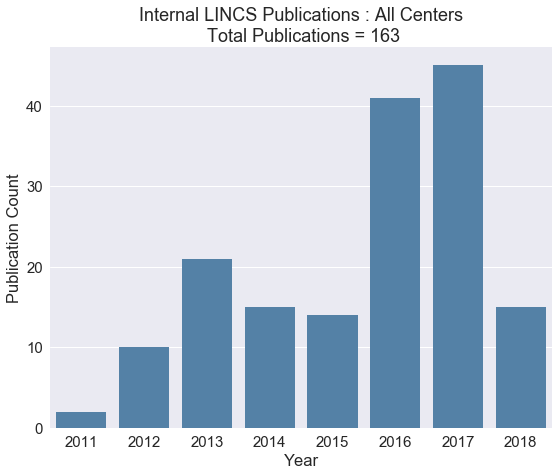

In [7]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100
years = internal.dropna(subset=['year_published'])['year_published'].astype(int)
years = years[years>1]
sn.countplot( years, color='steelblue')
plt.title('Internal LINCS Publications : All Centers\n Total Publications = '+
          str(len( internal )))
plt.xlabel('Year')
plt.ylabel('Publication Count');
# plt.ylim(0,50);

### Separated By Center

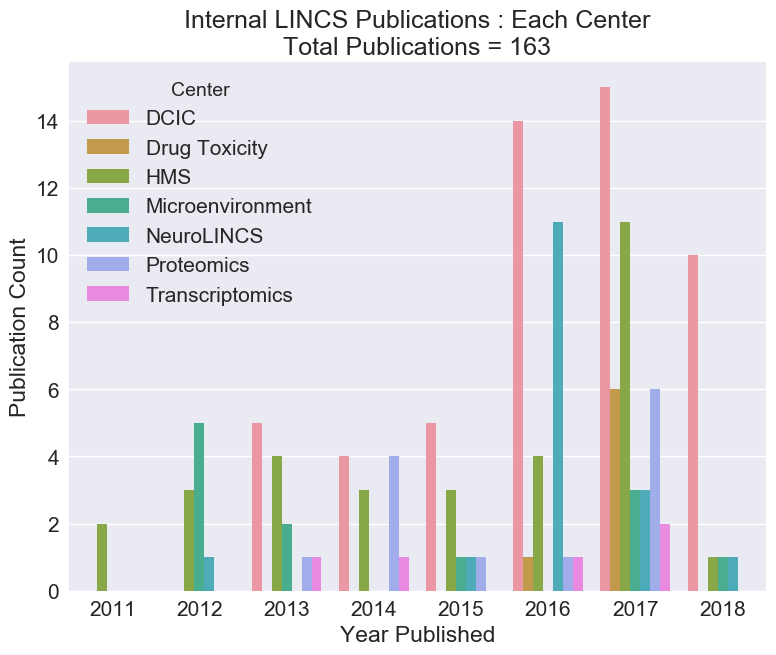

In [8]:
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100

internalByCenter = {}
for center in Centers: 
    internalByCenter[center] = internal.groupby('year_published')[center].sum()
    
internalByCenter = pd.DataFrame(internalByCenter).stack().reset_index()
internalByCenter.columns = ['year_published', 'Center', 'Count']
internalByCenter['year_published'] = internalByCenter['year_published'].astype(int)
sn.barplot(data=internalByCenter, x='year_published',y='Count',hue='Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len( internal ) ) )
plt.xlabel('Year Published')
plt.ylabel('Publication Count');
# plt.ylim(0,10);


## Internal LINCS CITATIONS

### Aggregated Across Centers

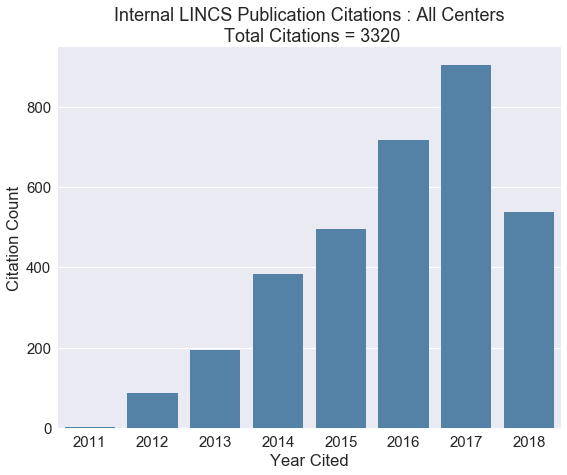

In [22]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100  
internal['year_published'] = internal['year_published'].astype(str)

from collections import Counter 
centerCounter={}     
for center in Centers:
    sub = internal.loc[internal[center]==1]
    yearCounter={}
    counter=Counter()
    for i,row in sub.iterrows(): 
        try:
            counter += Counter( row['citation_years'] )  
        except:
            counter += Counter()
    centerCounter[center]=counter
    
centerCounter = pd.DataFrame(centerCounter).fillna(0).stack().reset_index() 
centerCounter.rename(columns={'level_0':'year_cited','level_1':'LINCS Center',0:'count'}, inplace=True)
 
yearCounter_sum = centerCounter.groupby(['year_cited'])['count'].sum().reset_index()
yearCounter_sum = yearCounter_sum[yearCounter_sum['year_cited']!=0]
   
sn.barplot(data=yearCounter_sum, x='year_cited', y='count', color='steelblue')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count'); 
# plt.ylim(0,50);

### Separated By Center

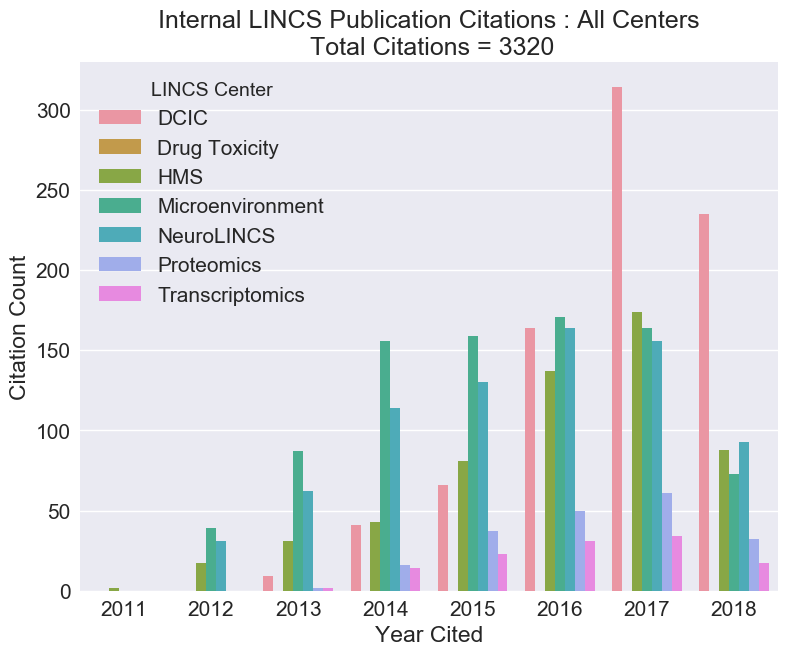

In [26]:
plt.figure(figsize=(9,7), dpi=100) # Default 8,6 #, dpi=100 

yearCounter_sum = centerCounter.groupby(['year_cited','LINCS Center'])['count'].sum().reset_index()
yearCounter_sum = yearCounter_sum[yearCounter_sum['year_cited']!=0]

sn.barplot(data=yearCounter_sum, x='year_cited', y='count', hue='LINCS Center')
plt.title('Internal LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(yearCounter_sum['count'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count');

## External LINCS Publications

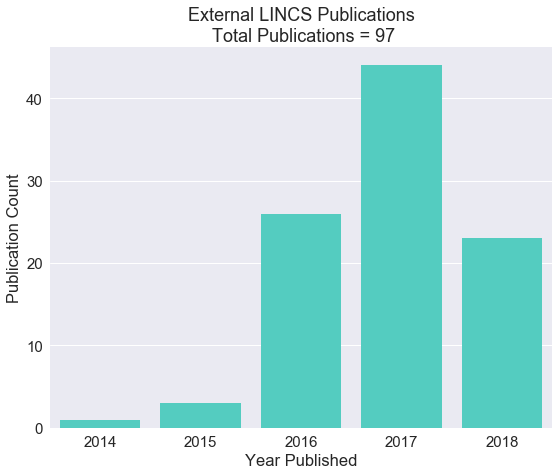

In [27]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100

years = external.dropna(subset=['year_published'])['year_published'].astype(int)
years = years[years>1]
sn.countplot( years, color='turquoise')
plt.title('External LINCS Publications\n Total Publications = '+str(len(years)))
plt.xlabel('Year Published')
plt.ylabel('Publication Count');
# plt.ylim(0,50);

## External LINCS Citations

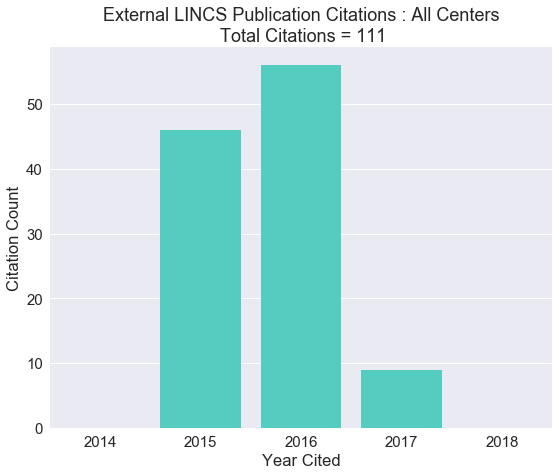

In [28]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100 
external['n_citations'] = external['n_citations'].fillna(0)
external['year_published'] = external.loc[:,'year_published'].astype(int)

grouped = external.groupby('year_published')['n_citations'].sum().reset_index()

sn.barplot(data=grouped, x='year_published', y='n_citations',  color='turquoise')
plt.title('External LINCS Publication Citations : All Centers\n Total Citations = '+\
          str( int(sum(external['n_citations'])) ))
plt.xlabel('Year Cited')
plt.ylabel('Citation Count'); 
# plt.ylim(0,50);